In [4]:
import os

from time import time
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
from os.path import join
import re
from multiprocessing import Pool
from joblib import Parallel, delayed

from tqdm import tqdm

from shapely import Point
import matplotlib.pyplot as plt


In [5]:
# if "client" not in locals():
#     cluster = LocalCluster(n_workers=48, threads_per_worker=1, memory_limit="4GB")
#     client = Client(cluster)
# else:
#     print("client already exists")
# print(client)

## Collect file names

In [6]:
base_path = "/home/patel_zeel/OpenAQ/PurpleAir"

if os.path.exists(join(base_path, "all_files.txt")):
    print("all_files.txt already exists. Reading it...")
    # read all files
    with open(join(base_path, "all_files.txt"), "r") as f:
        all_files = f.read().split("\n")
else:
    print("all_files.txt does not exist. Creating it...")
    # recursively read all files in the directory
    all_files = glob(join(base_path, "**/*.csv.gz"), recursive=True)
    with open(join(base_path, "all_files.txt"), "w") as f:
        f.write("\n".join(all_files))

files_df = pd.DataFrame(all_files, columns=["file_path"])
print(files_df.head(2))
print(files_df.shape)

all_files.txt already exists. Reading it...
                                           file_path
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...
(7554025, 1)


In [7]:
file = np.random.choice(all_files)
print(file)
tmp_df = pd.read_csv(file)
print(tmp_df["parameter"].value_counts())
tmp_df

/home/patel_zeel/OpenAQ/PurpleAir/data/locationid=233829/year=2022/month=07/location-233829-20220701.csv.gz
parameter
pm10     337
pm25     337
pm1      337
um010    337
um025    337
um100    337
Name: count, dtype: int64


station  sensors_id             location                   time  \
0          233829     1345337  Magnolia Ave-246125  2022-07-01T00:04:11-07:00   
1          233829     1345337  Magnolia Ave-246125  2022-07-01T00:06:11-07:00   
2          233829     1345337  Magnolia Ave-246125  2022-07-01T00:10:11-07:00   
3          233829     1345337  Magnolia Ave-246125  2022-07-01T00:20:11-07:00   
4          233829     1345337  Magnolia Ave-246125  2022-07-01T00:22:11-07:00   
...           ...         ...                  ...                        ...   
2017       233829     1345334  Magnolia Ave-246125  2022-07-01T23:36:26-07:00   
2018       233829     1345334  Magnolia Ave-246125  2022-07-01T23:42:26-07:00   
2019       233829     1345334  Magnolia Ave-246125  2022-07-01T23:44:26-07:00   
2020       233829     1345334  Magnolia Ave-246125  2022-07-01T23:54:26-07:00   
2021       233829     1345334  Magnolia Ave-246125  2022-07-01T23:58:26-07:00   

            lat        lon parameter          units  value  
0     38.251186 -122.67613      pm10          µg/m³  11.10  
1     38.251186 -122.67613      pm10          µg/m³  11.00  
2     38.251186 -122.67613      pm10          µg/m³   8.80  
3     38.251186 -122.67613      pm10          µg/m³  12.50  
4     38.251186 -122.67613      pm10          µg/m³  11.10  
...         ...        ...       ...            ...    ...  
2017  38.251186 -122.67613     um100  particles/cm³   0.01  
2018  38.251186 -122.67613     um100  particles/cm³   0.02  
2019  38.251186 -122.67613     um100  particles/cm³   0.01  
2020  38.251186 -122.67613     um100  particles/cm³   0.01  
2021  38.251186 -122.67613     um100  particles/cm³   0.00  

[2022 rows x 9 columns]

## Load California Shapefile

STATEFP COUNTYFP  COUNTYNS  GEOID        NAME           NAMELSAD LSAD  \
0      06      091  00277310  06091      Sierra      Sierra County   06   
1      06      067  00277298  06067  Sacramento  Sacramento County   06   

  CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER  \
0      H1  G4020   NaN    NaN      NaN        A  2468694587  23299110   
1      H1  G4020   472  40900      NaN        A  2499183617  76073827   

      INTPTLAT      INTPTLON  \
0  +39.5769252  -120.5219926   
1  +38.4500114  -121.3404409   

                                            geometry  
0  POLYGON ((-120.65560 39.69357, -120.65554 39.6...  
1  POLYGON ((-121.18858 38.71431, -121.18732 38.7...

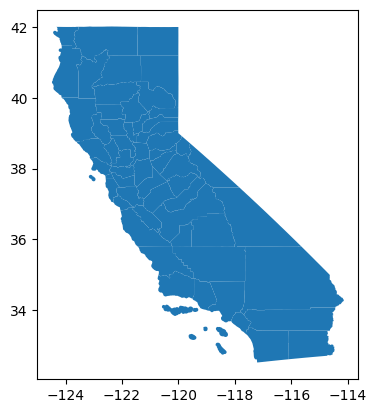

In [8]:
# download california state shapefile
import geopandas as gpd

california = gpd.read_file(
    "/home/patel_zeel/aq_data/aq_data/purpleair/raw/shapefiles/CA_Counties_TIGER2016.shp"
)
# set the crs to 4326 (lat/lon)
california = california.to_crs(epsg=4326)
california.plot()
california.head(2)

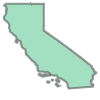

In [9]:
# convert all regions into a single polygon
poly = california["geometry"].unary_union
poly

In [10]:
# get the bounding box of the polygon
poly.bounds

(-124.48201686078049,
 32.52883673637251,
 -114.13122247508855,
 42.00950826967187)

## Find locations within California

In [11]:
# find all location ids from file names. Use `locationid` in regex for searching
init = time()
files_df["station"] = files_df.file_path.apply(
    lambda x: int(re.findall(r"locationid=(\d+)", x)[0])
)
print(f"Time taken: {time() - init:.2f} seconds")

unique_files_df = files_df.drop_duplicates(subset=["station"])

unique_files = unique_files_df.file_path.values
print("Unique files:", len(unique_files))

unique_locations = (
    unique_files_df["file_path"]
    .apply(lambda x: re.findall(r"locationid=(\d+)", x)[0])
    .values
)
assert len(set(unique_locations)) == len(unique_locations)


Time taken: 10.14 seconds
Unique files: 22497


In [12]:
print(files_df.head(2))
files_df.dtypes

                                           file_path  station
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873


file_path      object
station     int64
dtype: object

In [13]:
def get_metadata(file_name):
    df = pd.read_csv(file_name)
    lat = df["lat"].iloc[0]
    lon = df["lon"].iloc[0]
    station = df["station"].iloc[0]
    point = Point(lon, lat)
    in_california = poly.contains(point)
    return {
        "in_california": in_california,
        "latitude": lat,
        "longitude": lon,
        "station": station,
    }


with_dask = False
with_multiprocessing = True
init = time()

if with_dask:
    delayed_fn = dask.delayed(get_metadata)
else:
    delayed_fn = get_metadata

metadata_path = join(base_path, "metadata.nc")
print(metadata_path)
if os.path.exists(metadata_path):
    print("metadata already exists. Reading it...")
    metadata_ds = xr.open_dataset(metadata_path)
else:
    print("metadata does not exist. Creating it...")
    # took 1 minute to run
    metadata = []

    if with_multiprocessing:
        print("Running multiprocessing...")
        with Pool(48) as p:
            metadata = list(
                tqdm(
                    p.imap(delayed_fn, unique_files_df.file_path.values),
                    total=len(unique_files_df),
                )
            )
    else:
        print("Running delayed function...")
        for file in unique_files_df.file_path.values:
            metadata.append(delayed_fn(file))

        if with_dask:
            print("Computing...")
            metadata = dask.compute(*metadata)

    metadata_ds = pd.DataFrame(metadata).set_index("station").to_xarray()
    metadata_ds.to_netcdf(metadata_path)

print(f"Time taken: {(time() - init)/60} minutes")

metadata_ds = (
    metadata_ds.to_dataframe().reset_index().set_index(["in_california"]).to_xarray()
)
metadata_ds

/home/patel_zeel/OpenAQ/PurpleAir/metadata.nc
metadata already exists. Reading it...
Time taken: 0.000396879514058431 minutes


<xarray.Dataset>
Dimensions:        (in_california: 22497)
Coordinates:
  * in_california  (in_california) bool True True False ... False True False
Data variables:
    station    (in_california) int64 224873 73214 228621 ... 63314 234366
    latitude       (in_california) float64 37.81 37.89 39.12 ... 36.97 44.21
    longitude      (in_california) float64 -122.2 -122.3 ... -122.0 -122.3

In [14]:
in_cal_ds = metadata_ds.sel(in_california=True)
in_cal_df = in_cal_ds.to_dataframe()
print(in_cal_df.head(2))
print(in_cal_df.dtypes)

               station   latitude  longitude
in_california                                   
True                224873  37.806890 -122.21374
True                 73214  37.894917 -122.27640
station      int64
latitude       float64
longitude      float64
dtype: object


In [15]:
print(files_df.head(2))
files_df.station.unique().shape

                                           file_path  station
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873


(22497,)

In [16]:
cal_files_df = files_df.merge(in_cal_df, on="station", how="inner")
print(cal_files_df.head(2))
print(cal_files_df.shape)
print(cal_files_df.station.unique().shape)
cal_files_df.to_csv(join(base_path, "california_files.csv.gz"), index=False, compression="gzip")

                                           file_path  station  latitude  \
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873  37.80689   
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873  37.80689   

   longitude  
0 -122.21374  
1 -122.21374  
(4398787, 4)
(11618,)


In [17]:
join(base_path, "california_files.csv.gz")

'/home/patel_zeel/OpenAQ/PurpleAir/california_files.csv.gz'

In [18]:
loc_wise_files = cal_files_df.groupby("station").agg({"file_path": list}).sort_values("file_path", key=lambda x: x.str.len(), ascending=False)
loc_wise_files

file_path
station                                                   
62203        [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
62322        [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
62317        [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
62298        [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
62367        [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
...                                                        ...
225123       [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
602644       [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
225179       [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
226190       [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...
1658374      [/home/patel_zeel/OpenAQ/PurpleAir/data/locati...

[11618 rows x 1 columns]

In [19]:
loc_wise_files.file_path.iloc[0][0]

'/home/patel_zeel/OpenAQ/PurpleAir/data/locationid=62203/year=2023/month=02/location-62203-20230202.csv.gz'

In [39]:
cal_files_df['date'] = cal_files_df.file_path.apply(lambda x: re.findall(r"location-.*-(\d+)", x)[0])

Text(0, 0.5, 'Number of sensors')

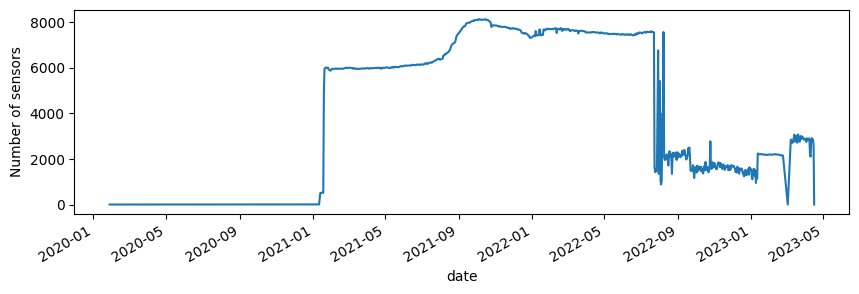

In [54]:
tmp_df = cal_files_df[cal_files_df.date.astype(int) > 20200000].date.value_counts().sort_index()
tmp_df.index = pd.to_time(tmp_df.index, format="%Y%m%d")
tmp_df.plot(figsize=(10,3))
plt.ylabel("Number of sensors")
# plt.xticks(pd.to_time(tmp_df.index));

In [20]:
# def combine_files(files):
#     station = re.findall(r"locationid=(\d+)", files[0])[0]
#     dfs = []
#     for file in files:
#         df = pd.read_csv(file)
#         dfs.append(df)
#     df = pd.concat(dfs)
#     # 2023-02-03T00:00:27-08:00
#     df = df[df.parameter == "pm25"]
#     df["time"] = pd.to_time(df["time"], format="%Y-%m-%dT%H:%M:%S%z")
#     df.sort_values("time", inplace=True)
#     df.set_index("time", inplace=True)
#     df = df.resample("H").mean()
#     df.to_csv("/home/patel_zeel/OpenAQ/PurpleAir/loc_combined/{}.csv.gz".format(station), index=False, compression="gzip")


# init = time()
# with Pool(48) as p:
#     _ = list(
#         tqdm(
#             p.imap(combine_files, loc_wise_files.file_path.values),
#             total=len(loc_wise_files.file_path.values),
#         )
#     )

# print(f"Time taken: {(time() - init)/60} minutes")
# # tqdm(Parallel(n_jobs=48)(delayed(combine_files)(files) for files in loc_wise_files.file_path.values), total=len(loc_wise_files))

## Checking availability statistics

In [2]:
cal_files_df["date"] = cal_files_df.file_path.apply(
    lambda x: re.findall(r"location-\d+-(\d{8})", x)[0]
)
cal_files_df["year"] = cal_files_df["date"].apply(lambda x: int(x[:4]))
cal_files_df["year-month"] = cal_files_df["date"].apply(lambda x: int(x[:6]))
cal_files_df.head(2)

NameError: name 'cal_files_df' is not defined

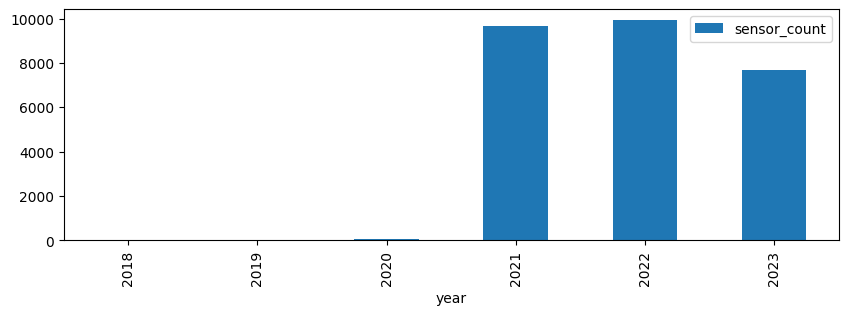

In [23]:
yearwise_counts = (
    cal_files_df.groupby(["year"])["station"]
    .nunique()
    .reset_index()
    .rename(columns={"station": "sensor_count"})
)
yearwise_counts.set_index("year").plot(kind="bar", figsize=(10, 3));

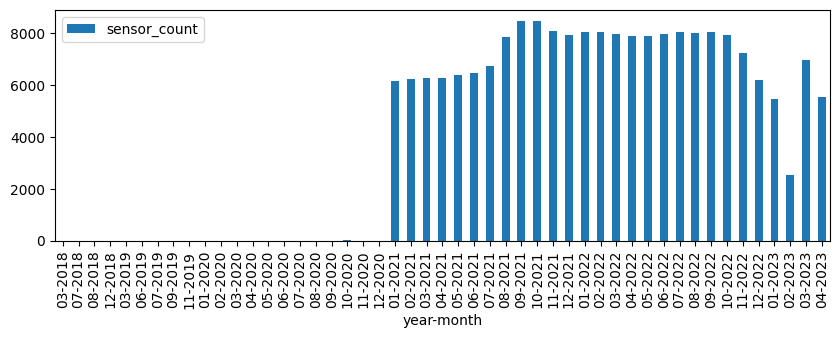

In [35]:
monthwise_counts = (
    cal_files_df.groupby(["year-month"])["station"]
    .nunique()
    .reset_index()
    .rename(columns={"station": "sensor_count"})
)
monthwise_counts = monthwise_counts.sort_values("year-month")
monthwise_counts.set_index("year-month").plot(kind="bar", figsize=(10, 3));
# set ticklabels as year-month. For example, for yearmonth value 202101, set ticklabel as Jan 2021

plt.xticks(
    range(len(monthwise_counts)), monthwise_counts["year-month"].astype(str).apply(lambda x: f"{x[4:]}-{x[:4]}")
);

In [36]:
loc_data = cal_files_df.groupby(["station", "year"])["date"].nunique()
# add lat/lon
loc_data = (
    loc_data.to_frame()
    .reset_index()
    .merge(
        cal_files_df[["station", "latitude", "longitude"]].drop_duplicates(),
        on="station",
        how="left",
    )
)
loc_data = loc_data.rename(columns={"date": "days"})
loc_data = loc_data.sort_values("days", ascending=False)

print(loc_data.head(2))

     station  year  days   latitude  longitude
261        62349  2021   353  37.811360 -122.29959
238        62341  2021   353  37.523067 -122.33837


In [41]:
locs_data_yearwise = loc_data.groupby("year").agg(
    {"station": list, "days": list, "latitude": list, "longitude": list}
)
locs_data_yearwise

station  \
year                                                      
2018                   [712358, 160372, 224727, 308749]   
2019  [885236, 885235, 160474, 221713, 223170, 35704...   
2020  [885548, 1016540, 62133, 390696, 831776, 85954...   
2021  [62349, 62341, 62455, 73087, 62343, 67223, 627...   
2022  [62196, 61964, 62077, 62203, 61987, 62194, 621...   
2023  [62322, 62302, 62249, 62406, 62342, 62434, 622...   

                                                   days  \
year                                                      
2018                                       [1, 1, 1, 1]   
2019               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
2020  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2021  [353, 353, 353, 353, 353, 353, 353, 353, 353, ...   
2022  [333, 329, 328, 328, 326, 325, 325, 324, 323, ...   
2023  [92, 91, 91, 91, 90, 90, 90, 90, 90, 90, 90, 9...   

                                               latitude  \
year                                                      
2018        [34.046722, 38.13838, 37.642166, 34.110794]   
2019  [34.031967, 34.044834, 33.753635, 34.0184, 34....   
2020  [37.84299, 38.485783, 37.78546, 36.9916, 33.53...   
2021  [37.81136, 37.523067, 34.1804, 37.390903, 38.1...   
2022  [37.67254, 38.123096, 37.220757, 33.86301, 37....   
2023  [37.50588, 37.79617, 37.404026, 34.021534, 37....   

                                              longitude  
year                                                     
2018   [-118.15533, -121.30097, -120.99426, -117.32494]  
2019  [-117.172066, -118.000015, -117.85664, -118.16...  
2020  [-122.2923, -121.44173, -122.42678, -122.06831...  
2021  [-122.29959, -122.33837, -118.89463, -122.2769...  
2022  [-120.35794, -122.584305, -119.6835, -118.3889...  
2023  [-122.31254, -121.93064, -122.09847, -117.9099...

In [52]:
# create a table with rows as years and columns as percentage of days with data. Total days in a year = 365.

percentage_by_year = {}
for year in locs_data_yearwise.index:
    if year > 2020 and year < 2023:
        locs = locs_data_yearwise.loc[year]["station"]
        days = locs_data_yearwise.loc[year]["days"]
        total_days = 365
        percentage_by_year[year] = {"90": np.sum(np.array(days) >= 0.9 * total_days)/len(locs) * 100,
                                    "80": np.sum(np.array(days) >= 0.8 * total_days)/len(locs) * 100,
                                    "70": np.sum(np.array(days) >= 0.7 * total_days)/len(locs) * 100,
                                    "60": np.sum(np.array(days) >= 0.6 * total_days)/len(locs) * 100,
                                    }
        
pd.DataFrame(percentage_by_year)

2021       2022
90  44.010336   0.020153
80  50.904393   1.985087
70  56.031008  11.507457
60  60.434109  58.464329

In [31]:
percentage = 90
min_days = int(365 * percentage / 100)
print(f"Minimum days: {min_days}")

loc_suff_data = locs_data_2022[locs_data_2022.days >= min_days]
print(loc_suff_data.shape)
print(loc_suff_data.head(2))


Minimum days: 328
(4, 5)
    station  year  days   latitude   longitude
59        62196  2022   333  37.672540 -120.357940
12        61964  2022   329  38.123096 -122.584305


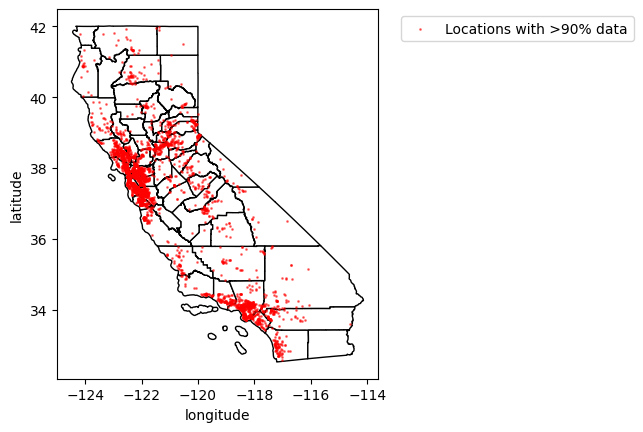

In [19]:
fig, ax = plt.subplots()
california.plot(ax=ax, color="white", edgecolor="black")
loc_suff_data.plot(
    x="longitude",
    y="latitude",
    kind="scatter",
    s=1,
    ax=ax,
    color="red",
    alpha=0.5,
    label=f"Locations with >{percentage}% data",
)
_ = plt.legend(bbox_to_anchor=(1.05, 1))

In [1]:
california

NameError: name 'california' is not defined

In [20]:
suff_data_files = cal_files_df[cal_files_df.station.isin(loc_suff_data.station)]
suff_data_files = suff_data_files[suff_data_files.year == 2021]
print(suff_data_files.shape)
print(suff_data_files.head(2))


(1479138, 7)
                                             file_path  station  \
521  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...        73214   
522  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...        73214   

      latitude  longitude      date  year  year-month  
521  37.894917  -122.2764  20210727  2021      202107  
522  37.894917  -122.2764  20210723  2021      202107  


## Read and Combine Data

In [21]:
# init = time()
# ddf_list = dask.compute(*[dask.delayed(dd.read_csv)(file, blocksize=None) for file in suff_data_files.file_path.values])
# print(f"Read time: {(time() - init)/60} minutes")

# ddf_combined = dd.concat(ddf_list)
# ddf_combined.head(2)


In [22]:
import gzip
import shutil
from multiprocessing import Pool

save_dir = "/home/patel_zeel/aqmsp/aqmsp_data/data/purpleair/2021"
os.makedirs(save_dir, exist_ok=True)


def extract_gz(file):
    last_name = file.split("/")[-1].replace(".gz", "")
    with gzip.open(file, "rb") as f_in:
        if os.path.exists(join(save_dir, last_name)):
            return 1
        with open(join(save_dir, last_name), "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    return 1


init = time()
with Pool(48) as p:
    _ = list(
        tqdm(
            p.imap(extract_gz, suff_data_files.file_path.values),
            total=len(suff_data_files),
        )
    )

print(f"Time taken: {(time() - init)/60} minutes")

100%|██████████| 1479138/1479138 [01:09<00:00, 21426.76it/s]


Time taken: 1.1845959742863974 minutes


In [23]:
4000 * 365, 1479138


(1460000, 1479138)

For year 2021, above process took around 16 minutes to complete with dask.

In [15]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.rand(5), index=range(5))
df.loc[1] = np.nan
df.loc[3] = np.nan
print(df)
good_df = df.dropna()
good_df

          0
0  0.278791
1       NaN
2  0.576965
3       NaN
4  0.625871


0
0  0.278791
2  0.576965
4  0.625871

In [16]:
good_df[0] = 10
good_df

/tmp/ipykernel_486203/1559062261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_df[0] = 10


0
0  10
2  10
4  10

In [17]:
df[0] = good_df[0]
df

0
0  10.0
1   NaN
2  10.0
3   NaN
4  10.0